<a href="https://colab.research.google.com/github/gigisy/Capstone-SP-IPT/blob/main/Analisis_Full/ANALISIS_MahaData_(KELOMPOK_4)_DAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. PRODUK TERLARIS DAN KURANG LAKU

Untuk menjawab soal ini dapat dilihat pada Tableau terdapat chart yang berjudul Total Product with High Repeat Orders dan Sum of Product based on Customers.

Pada Bagian colab ini kami hanya menampilkan berapa banyak produk yang dipesan oleh customer dengan repeat order hanya 1 hingga 5 kali.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_outgoing = '/content/drive/MyDrive/DATA FIXX BENERAN DIPAKE/Outgoing_FIX_Beneran.xlsx'

In [ ]:
# Membaca data transaksi
outgoing_df = pd.read_excel(file_outgoing)
outgoing_df

In [ ]:
outgoing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303369 entries, 0 to 303368
Data columns (total 13 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Number                               303369 non-null  object        
 1   Customer/RecordName                  303369 non-null  object        
 2   Shipping Type                        303369 non-null  object        
 3   Inventory Moves/Product/Record Name  303369 non-null  object        
 4   Inventory Moves/Internal Quantity    303369 non-null  int64         
 5   Pickup No                            303369 non-null  object        
 6   Invoice No                           303369 non-null  object        
 7   Sale Date                            303369 non-null  datetime64[ns]
 8   Document No                          303369 non-null  object        
 9   Done at                              303369 non-null  datetime64[ns]
 

In [ ]:
# Hitung jumlah pelanggan unik yang melakukan repeat order per produk
unique_repeat_customers = outgoing_df.groupby('Inventory Moves/Product/Record Name')['Customer/RecordName'].nunique().reset_index()

# Ubah nama kolom agar lebih mudah dipahami
unique_repeat_customers.columns = ['Product', 'UniqueRepeatCustomers']

# Urutkan data berdasarkan jumlah pelanggan unik (descending)
unique_repeat_customers = unique_repeat_customers.sort_values(by=['UniqueRepeatCustomers'], ascending=False)

# Tampilkan data
display(unique_repeat_customers)

# Produk dengan pelanggan unik terbanyak yang melakukan repeat order
highest_unique_repeat_product = unique_repeat_customers.iloc[0]

# Produk dengan pelanggan unik paling sedikit yang melakukan repeat order
lowest_unique_repeat_product = unique_repeat_customers.iloc[-1]

# Tampilkan hasil
print(f"Produk dengan pelanggan unik terbanyak yang melakukan repeat order: {highest_unique_repeat_product['Product']} ({highest_unique_repeat_product['UniqueRepeatCustomers']} pelanggan)")
print(f"Produk dengan pelanggan unik paling sedikit yang melakukan repeat order: {lowest_unique_repeat_product['Product']} ({lowest_unique_repeat_product['UniqueRepeatCustomers']} pelanggan)")

In [ ]:
# Hitung jumlah repeat order per produk per pelanggan
repeat_orders_per_customer = outgoing_df.groupby(['Customer/RecordName', 'Inventory Moves/Product/Record Name'])['Number'].count().reset_index()
repeat_orders_per_customer.columns = ['Customer', 'Product', 'RepeatOrderCount']

# Hitung jumlah produk untuk setiap jumlah repeat order
repeat_order_counts = repeat_orders_per_customer.groupby('RepeatOrderCount')['Product'].nunique().reset_index()
repeat_order_counts.columns = ['RepeatOrderCount', 'ProductCount']

# Filter untuk repeat order 1 sampai 5
repeat_order_counts_1_to_5 = repeat_order_counts[repeat_order_counts['RepeatOrderCount'].between(1, 5)]


# Tampilkan hasil
for index, row in repeat_order_counts_1_to_5.iterrows():
    print(f"Jumlah produk yang di-repeat order sebanyak {row['RepeatOrderCount']} kali: {row['ProductCount']}")

Jumlah produk yang di-repeat order sebanyak 1 kali: 24751
Jumlah produk yang di-repeat order sebanyak 2 kali: 11011
Jumlah produk yang di-repeat order sebanyak 3 kali: 5196
Jumlah produk yang di-repeat order sebanyak 4 kali: 2770
Jumlah produk yang di-repeat order sebanyak 5 kali: 1627


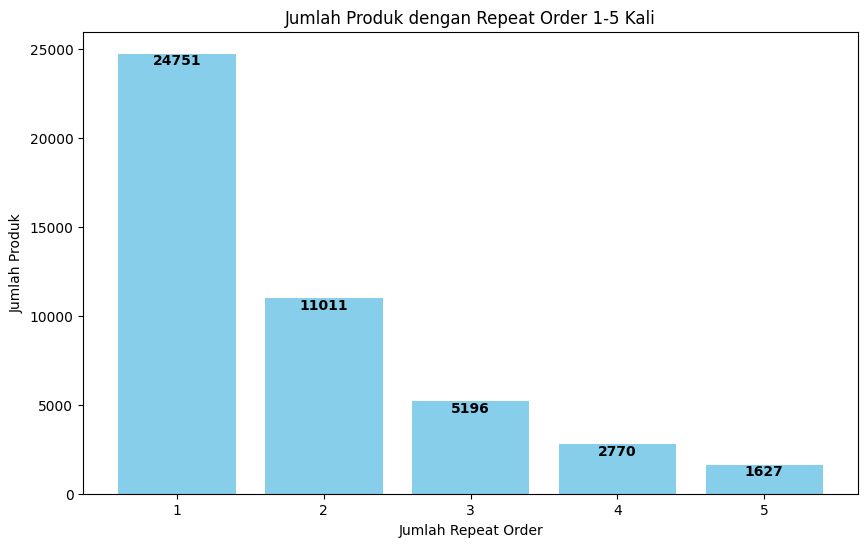

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (kode sebelumnya untuk menghitung repeat_order_counts_1_to_5) ...

# Buat bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(repeat_order_counts_1_to_5['RepeatOrderCount'], repeat_order_counts_1_to_5['ProductCount'], color='skyblue')

# Tambahkan angka di dalam bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 5 , round(yval,0), ha='center', va='top', color='black', fontweight='bold')


# Atur label dan judul
plt.xlabel("Jumlah Repeat Order")
plt.ylabel("Jumlah Produk")
plt.title("Jumlah Produk dengan Repeat Order 1-5 Kali")

plt.xticks(repeat_order_counts_1_to_5['RepeatOrderCount'])  # Menampilkan semua nilai RepeatOrderCount pada sumbu x

# Tampilkan bar chart
plt.show()

# 2. ANALISIS EVALUASI PEMASARAN

## Import Dataset Yang Akan Digunakan

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_outgoing = '/content/drive/MyDrive/DATA FIXX BENERAN DIPAKE/Outgoing_FIX_Beneran.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Membaca data transaksi
outgoing_df = pd.read_excel(file_outgoing)
outgoing_df

In [ ]:
outgoing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303369 entries, 0 to 303368
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   Number                               303369 non-null  object        
 1   Customer/RecordName                  303369 non-null  object        
 2   Shipping Type                        303369 non-null  object        
 3   Inventory Moves/Product/Record Name  303369 non-null  object        
 4   Inventory Moves/Internal Quantity    303369 non-null  int64         
 5   Pickup No                            303369 non-null  object        
 6   Invoice No                           303369 non-null  object        
 7   Sale Date                            303369 non-null  datetime64[ns]
 8   Document No                          303369 non-null  object        
 9   Done at                              303369 non-null  datetime64[ns]
 

In [ ]:
outgoing_df['Bulan'] = outgoing_df['Sale Date'].dt.month
outgoing_df

## Pemodelan Regresi Linier dengan Metode WLS

### Label Encoder

In [ ]:
# ENCODE DATASET dengan Drop 1 Kolom Shipping Type dan Bulan
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop satu kolom untuk menghindari dummy trap
encoded_cols = encoder.fit_transform(outgoing_df[['Shipping Type', 'Bulan']])
encoded_col_names = encoder.get_feature_names_out(['Shipping Type', 'Bulan'])

In [ ]:
df_encoded = pd.DataFrame(encoded_cols, columns=encoded_col_names)

In [ ]:
df_final = pd.concat([outgoing_df.drop(columns=['Shipping Type', 'Bulan']), df_encoded], axis=1)
df_final

### Pemodelan

In [ ]:
# Pisahkan X (fitur) dan y (target)
X = df_final.drop(columns=['Delay'])
y = df_final['Delay']

In [ ]:
# Memilih Variabel yang digunakan sebagai X
X = df_final.drop(columns=['Delay', 'Number', 'State', 'Done at', 'Document No', 'Sale Date', 'Invoice No', 'Pickup No', 'Inventory Moves/Internal Quantity', 'Inventory Moves/Product/Record Name', 'Customer/RecordName'])

In [ ]:
# Tambahkan konstanta untuk regresi
X = sm.add_constant(X)

In [ ]:
# # Drop baris dengan NaN
# X = X.dropna()
# y = y[X.index]  # Sinkronkan indeks X dan y

In [ ]:
X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303369 entries, 0 to 303368
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   const                   303369 non-null  float64
 1   Shipping Type_Expedisi  303369 non-null  float64
 2   Shipping Type_Kirim     303369 non-null  float64
 3   Bulan_2                 303369 non-null  float64
 4   Bulan_3                 303369 non-null  float64
 5   Bulan_4                 303369 non-null  float64
 6   Bulan_5                 303369 non-null  float64
 7   Bulan_6                 303369 non-null  float64
 8   Bulan_7                 303369 non-null  float64
dtypes: float64(9)
memory usage: 20.8 MB
<class 'pandas.core.series.Series'>
Index: 303369 entries, 0 to 303368
Series name: Delay
Non-Null Count   Dtype
--------------   -----
303369 non-null  int64
dtypes: int64(1)
memory usage: 4.6 MB


In [ ]:
# Regresi WLS
model = sm.WLS(y, X)
results = model.fit()

# Hasil regresi
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:                  Delay   R-squared:                       0.108
Model:                            WLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     4574.
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        08:24:31   Log-Likelihood:            -1.1764e+06
No. Observations:              303369   AIC:                         2.353e+06
Df Residuals:                  303360   BIC:                         2.353e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     17

Didapatkan bahwa Shipping Type Ekspedisi signifikan terhadap Delay dan Bulan 2 (Februari) juga signifikan terhadap Delay. Hal ini berarti bahwa pada jenis pengiriman ekspedisi dan pada bulan Februari memiliki jumlah delay yang tinggi.

# 3. ANALISIS SEGMENTASI PELANGGAN

In [ ]:
# Hitung nilai R (Recency)
most_recent_date = outgoing_df['Sale Date'].max()
outgoing_df['R'] = (most_recent_date - outgoing_df['Sale Date']).dt.days

# Hitung nilai F (Frequency)
F_values = outgoing_df.groupby('Customer/RecordName')['Number'].nunique()

# Hitung nilai M (Monetary)
customer_quantity = outgoing_df.groupby('Customer/RecordName')['Inventory Moves/Internal Quantity'].sum().reset_index()
customer_quantity.rename(columns={'Inventory Moves/Internal Quantity': 'M'}, inplace=True)

# Gabungkan R, F, dan M ke DataFrame baru
rfm_df = pd.DataFrame({'Customer': F_values.index, 'F': F_values.values})
rfm_df = pd.merge(rfm_df, outgoing_df[['Customer/RecordName', 'R']], left_on='Customer', right_on='Customer/RecordName', how='left')
rfm_df = pd.merge(rfm_df, customer_quantity[['Customer/RecordName', 'M']], left_on='Customer', right_on='Customer/RecordName', how='left')
rfm_df = rfm_df[['Customer', 'R', 'F', 'M']]
rfm_df.drop_duplicates(subset='Customer', inplace=True)

# Tampilkan DataFrame RFM
display(rfm_df)

In [ ]:
# Buat kuartil untuk R, F, dan M
rfm_df['R_Quartile'] = pd.qcut(rfm_df['R'], 4, labels=[4, 3, 2, 1])  # Recency: Semakin rendah semakin baik
rfm_df['F_Quartile'] = pd.qcut(rfm_df['F'], 4, labels=[1, 2, 3, 4], duplicates='drop')  # Frequency: Semakin tinggi semakin baik
rfm_df['M_Quartile'] = pd.qcut(rfm_df['M'], 4, labels=[1, 2, 3, 4], duplicates='drop')  # Monetary: Semakin tinggi semakin baik

In [ ]:
# Menampilkan rentang nilai untuk skor R
print("Rentang nilai Recency (R):")
for i in range(1, 5):
  # Filter DataFrame rfm_df berdasarkan R_Quartile
  quartile_data = rfm_df[rfm_df['R_Quartile'] == i]

  # Dapatkan nilai minimum dan maksimum dari kolom R
  min_value = quartile_data['R'].min()
  max_value = quartile_data['R'].max()

  # Cetak rentang nilai untuk skor R saat ini
  print(f"Skor R {i}: {min_value} - {max_value}")

Rentang nilai Recency (R):
Skor R 1: 184 - 192
Skor R 2: 155 - 183
Skor R 3: 71 - 154
Skor R 4: 0 - 70


In [ ]:
# Menampilkan rentang nilai untuk skor F
print("\nRentang nilai Frequency (F):")
for i in range(1, 5):
  # Filter DataFrame rfm_df berdasarkan F_Quartile
  quartile_data = rfm_df[rfm_df['F_Quartile'] == i]

  # Dapatkan nilai minimum dan maksimum dari kolom F
  min_value = quartile_data['F'].min()
  max_value = quartile_data['F'].max()

  # Cetak rentang nilai untuk skor F saat ini
  print(f"Skor F {i}: {min_value} - {max_value}")


Rentang nilai Frequency (F):
Skor F 1: 1 - 2
Skor F 2: 3 - 4
Skor F 3: 5 - 10
Skor F 4: 11 - 1680


In [ ]:
# Menampilkan rentang nilai untuk skor M
print("\nRentang nilai Monetary (M):")
for i in range(1, 5):
  # Filter DataFrame rfm_df berdasarkan M_Quartile
  quartile_data = rfm_df[rfm_df['M_Quartile'] == i]

  # Dapatkan nilai minimum dan maksimum dari kolom M
  min_value = quartile_data['M'].min()
  max_value = quartile_data['M'].max()

  # Cetak rentang nilai untuk skor M saat ini
  print(f"Skor M {i}: {min_value} - {max_value}")


Rentang nilai Monetary (M):
Skor M 1: 1 - 60
Skor M 2: 61 - 416
Skor M 3: 417 - 1732
Skor M 4: 1737 - 3436339


In [ ]:
# Buat kuartil untuk R, F, dan M
rfm_df['R_Quartile'] = pd.qcut(rfm_df['R'], 4, labels=[4, 3, 2, 1])  # Recency: Semakin rendah semakin baik
rfm_df['F_Quartile'] = pd.qcut(rfm_df['F'], 4, labels=[1, 2, 3, 4], duplicates='drop')  # Frequency: Semakin tinggi semakin baik
rfm_df['M_Quartile'] = pd.qcut(rfm_df['M'], 4, labels=[1, 2, 3, 4], duplicates='drop')  # Monetary: Semakin tinggi semakin baik


# Tampilkan DataFrame RFM dengan kuartil
display(rfm_df)

#### PELANGGAN TERBAIK

In [ ]:
# Filter pelanggan dengan skor RFM 4 4 4
best_customers = rfm_df[(rfm_df['R_Quartile'] == 4) & (rfm_df['F_Quartile'] == 4) & (rfm_df['M_Quartile'] == 4)]

# Tampilkan pelanggan terbaik
print("Pelanggan Terbaik (RFM 4 4 4):")
display(best_customers)

#### PELANGGAN LOYAL

In [ ]:
# Filter pelanggan loyal
loyal_customers = rfm_df[
    (rfm_df['R_Quartile'].astype(int) >= 3) &  # R ≥ 3
    (rfm_df['F_Quartile'] == 4) &  # F = 4
    (rfm_df['M_Quartile'].astype(int) >= 3) &  # M ≥ 3
    ~((rfm_df['R_Quartile'] == 4) & (rfm_df['F_Quartile'] == 4) & (rfm_df['M_Quartile'] == 4))  # Tidak termasuk RFM 4 4 4
]

print("Pelanggan Loyal:")
display(loyal_customers)
loyal_customers.shape[0]

#### PELANGGAN BARU AKHIR-AKHIR INI

In [ ]:
# Filter pelanggan baru akhir-akhir ini
recent_new_customers = rfm_df[
    (rfm_df['R_Quartile'] == 4) &  # R = 4
    (rfm_df['F_Quartile'] == 1) &  # F = 1
    (rfm_df['M_Quartile'].astype(int) >= 1)  # M ≥ 1
]

print("Pelanggan Baru Akhir-akhir ini:")
display(recent_new_customers)

#### PELANGGAN BARU YANG MENJANJIKAN

In [ ]:
# Filter pelanggan baru yang menjanjikan
promising_new_customers = rfm_df[
    (rfm_df['R_Quartile'] == 4) &  # R = 4
    (rfm_df['F_Quartile'] == 1) &  # F = 1
    (rfm_df['M_Quartile'].astype(int) >= 3)  # M ≥ 3
]

print("Pelanggan Baru yang Menjanjikan:")
display(promising_new_customers)

#### PELANGGAN COBA-COBA

In [ ]:
# Filter pelanggan yang coba-coba
experimental_customers = rfm_df[
    (rfm_df['R_Quartile'].astype(int) >= 1) & (rfm_df['R_Quartile'].astype(int) <= 3) &  # 1 ≤ R ≤ 3
    (rfm_df['F_Quartile'] == 1) &  # F = 1
    (rfm_df['M_Quartile'].astype(int) >= 1) & (rfm_df['M_Quartile'].astype(int) <= 4)  # 1 ≤ M ≤ 4
]

print("Pelanggan yang Coba-coba:")
display(experimental_customers)

#### PELANGGAN BERISIKO HILANG

In [ ]:
# Filter pelanggan berisiko hilang
at_risk_customers = rfm_df[
    (rfm_df['R_Quartile'].astype(int) >= 1) & (rfm_df['R_Quartile'].astype(int) <= 3) &  # 1 ≤ R ≤ 3
    (rfm_df['F_Quartile'] >= 3) &  # F = 4
    (rfm_df['M_Quartile'] >= 1)  # M = 1
]

# Tampilkan pelanggan berisiko hilang
print("Pelanggan Beresiko Hilang (R=1-3, F=4, M>=1):")
display(at_risk_customers)

### Pelanggan Aktif dengan Nilai Belanja Rendah

In [ ]:
# Filter untuk segmen 'Pelanggan Aktif dengan Nilai Belanja Rendah'
low_spending_active_customers = rfm_df[
    (rfm_df['R_Quartile'].astype(int).isin([4])) &  # R = 3-4
    (rfm_df['F_Quartile'].astype(int).isin([4, 3])) &  # F = 2-3
    (rfm_df['M_Quartile'].astype(int).isin([1, 2]))  # M = 1-2
]

# Tampilkan pelanggan dalam segmen ini
print("Pelanggan Aktif dengan Nilai Belanja Rendah:")
display(low_spending_active_customers)
low_spending_active_customers.shape[0]

### Pelanggan tidak masuk segmen


In [ ]:
# Gabungkan semua kondisi filter untuk semua segmen
all_segments_condition = (
    # Pelanggan Terbaik (R=4, F=4, M=4)
    ((rfm_df['R_Quartile'] == 4) & (rfm_df['F_Quartile'] == 4) & (rfm_df['M_Quartile'] == 4)) |
    # Pelanggan Loyal (R≥3, F=4, M≥3, excluding Best Customers)
    ((rfm_df['R_Quartile'].astype(int) >= 3) & (rfm_df['F_Quartile'] == 4) & (rfm_df['M_Quartile'].astype(int) >= 3) &
     ~((rfm_df['R_Quartile'] == 4) & (rfm_df['F_Quartile'] == 4) & (rfm_df['M_Quartile'] == 4))) |
    # Pelanggan baru akhir akhir ini (R=4, F=1, M≥1)
    ((rfm_df['R_Quartile'] == 4) & (rfm_df['F_Quartile'] == 1) & (rfm_df['M_Quartile'].astype(int) >= 1)) |
    # Pelanggan baru yang menjanjikan (R=4, F=1, M≥3)
    ((rfm_df['R_Quartile'] == 4) & (rfm_df['F_Quartile'] == 1) & (rfm_df['M_Quartile'].astype(int) >= 3)) |
    # Pelanggan yang Coba-coba (R=1-3, F=1, M=1-4)
    ((rfm_df['R_Quartile'].astype(int) >= 1) & (rfm_df['R_Quartile'].astype(int) <= 3) &
     (rfm_df['F_Quartile'] == 1) & (rfm_df['M_Quartile'].astype(int) >= 1) & (rfm_df['M_Quartile'].astype(int) <= 4)) |
    # Pelanggan beresiko hilang (R=1-3, F>=3, M>=1) # At Risk Customer
    ((rfm_df['R_Quartile'].astype(int) >= 1) & (rfm_df['R_Quartile'].astype(int) <= 3) &
     (rfm_df['F_Quartile'] >= 3) & (rfm_df['M_Quartile'] >= 1)) | # Added "|" to connect with the next condition
    #elanggan Aktif dengan Nilai Belanja Rendah
    ((rfm_df['R_Quartile'].astype(int).isin([3, 4])) & (rfm_df['F_Quartile'].astype(int).isin([4, 3])) & (rfm_df['M_Quartile'].astype(int).isin([1, 2])))  # M = 1-2
)

# Filter pelanggan yang TIDAK termasuk dalam semua segmen
customers_outside_segments = rfm_df[~all_segments_condition]

# Tampilkan pelanggan yang TIDAK termasuk dalam semua segmen
print("Pelanggan di Luar Semua Segmen:")
display(customers_outside_segments)

# 4. INSIGHT LAIN

## Kontribusi Pelanggan

### PELANGGAN DENGAN PEMBELIAN TERBESAR

In [ ]:
# Hitung total pembelian per pelanggan
total_per_pelanggan = outgoing_df.groupby("Customer/RecordName")["Inventory Moves/Internal Quantity"].sum().reset_index()

# Identifikasi pelanggan dengan pembelian terbanyak
top_customer = total_per_pelanggan.loc[total_per_pelanggan["Inventory Moves/Internal Quantity"].idxmax()]

print("PELANGGAN DENGAN PEMBELIAN TERBESAR")
print("-" * 40)
print(f"Nama Pelanggan    : {top_customer['Customer/RecordName']}")
print(f"Total Pembelian   : {top_customer['Inventory Moves/Internal Quantity']:,}")  # Format angka dengan koma
print("-" * 40)

### Kontribusi Pelanggan terhadap Penjualan

In [ ]:
# Hitung total pembelian per pelanggan
total_per_pelanggan = outgoing_df.groupby("Customer/RecordName")["Inventory Moves/Internal Quantity"].sum().reset_index()

# Analisis frekuensi pembelian
frekuensi_pembelian = outgoing_df.groupby("Customer/RecordName")["Sale Date"].count().reset_index()
frekuensi_pembelian.columns = ["Customer/RecordName", "purchase_frequency"]

# Gabungkan dengan total pembelian untuk analisis pola
behavior_analysis = pd.merge(total_per_pelanggan, frekuensi_pembelian, on="Customer/RecordName")

# Hitung total penjualan keseluruhan
total_penjualan = outgoing_df["Inventory Moves/Internal Quantity"].sum()

# Tambahkan kolom kontribusi di DataFrame
behavior_analysis["contribution_percentage"] = (
    behavior_analysis["Inventory Moves/Internal Quantity"] / total_penjualan * 100)

# Ambil 10 pelanggan dengan pembelian tertinggi
top_10_customers = behavior_analysis.sort_values("Inventory Moves/Internal Quantity", ascending=False).head(10)

print("ANALISIS POLA PEMBELIAN PELANGGAN")
print("-" * 70)
print(f"{'Nama Pelanggan':<20}{'Total Pembelian':<20}{'Kontribusi (%)':<15}{'Frekuensi':<10}")
print("-" * 70)

for index, row in top_10_customers.iterrows():
    print(f"{row['Customer/RecordName']:<20}{row['Inventory Moves/Internal Quantity']:<20,}{row['contribution_percentage']:<15.2f}{row['purchase_frequency']:<10}")

print("-" * 70)

In [ ]:
# Hitung total penjualan keseluruhan
total_penjualan = outgoing_df["Inventory Moves/Internal Quantity"].sum()

# Tambahkan kolom kontribusi di DataFrame
total_per_pelanggan["contribution_percentage"] = (
    total_per_pelanggan["Inventory Moves/Internal Quantity"] / total_penjualan * 100)

# Lihat kontribusi pelanggan terbesar
top_customer_contribution = total_per_pelanggan.loc[total_per_pelanggan["Customer/RecordName"] == top_customer["Customer/RecordName"]]

print("KONTRIBUSI PELANGGAN TOP TERHADAP TOTAL PENJUALAN")
print("-" * 50)
print(f"Nama Pelanggan     : {top_customer_contribution['Customer/RecordName'].values[0]}")
print(f"Total Pembelian    : {top_customer_contribution['Inventory Moves/Internal Quantity'].values[0]:,}")
print(f"Kontribusi (%)     : {top_customer_contribution['contribution_percentage'].values[0]:.2f}%")
print("-" * 50)

### JIKA PELANGGAN BERHENTI BERLANGGANAN

In [ ]:
# Total penjualan semua pelanggan
total_penjualan = outgoing_df["Inventory Moves/Internal Quantity"].sum()

# total penjualan
print("Total semua penjualan:", f"{total_penjualan:,}")

In [ ]:
# Jika pelanggan berhenti
penjualan_tanpa_top = total_penjualan - top_customer["Inventory Moves/Internal Quantity"]

print("Penjualan dengan pelanggan aktif:", f"{total_penjualan:,}")
print("Penjualan tanpa pelanggan tersebut:", f"{penjualan_tanpa_top:,}")
print("Penurunan dalam penjualan:", f"{total_penjualan - penjualan_tanpa_top:,}")

In [ ]:
# Menghitung total penjualan tanpa pelanggan terbesar
penjualan_tanpa_top = total_penjualan - top_customer["Inventory Moves/Internal Quantity"]

# Menghitung penurunan penjualan
penurunan_penjualan = total_penjualan - penjualan_tanpa_top

# Menghitung persentase penurunan
penurunan_persen = (penurunan_penjualan / total_penjualan) * 100

# Tampilkan hasil
print("Penurunan dalam penjualan:", f"{penurunan_penjualan:,}")
print("Penurunan dalam persentase:", f"{penurunan_persen:.2f}%")

Dari keseluruhan persentase penjualan produk, angka tertinggi yaitu sebesar 15% oleh pelanggan dengan nama AB*******. Hal ini mengartikan bahwa kondisi penjualan pada Perusahaan A tidak hanya bergantung pada satu pelanggan besar saja, sehingga jika pelanggan AB*******. berhenti berlangganan pada Perusahaan A, maka tidak mengganggu kondisi pasar Perusahaan A.